# YOLO 학습을 위한 셋팅
*   이미지파일 + 각각의 txt 어노테이션 파일
*   YOLO 어노테이션 포맷: `<object-class> <x_center> <y_center> <width> <height>`
*   yaml 파일 필요

위에 파일을들 한곳에 압축해 한번에 형식에 맞게 풀면 정말정말 좋겠다...
(용량커서 튕김)
*   데이터셋
    - train: 14000장 중 현재는 약 만장
    - valid: 만장중에서 떼서 쓸 예정
    - test: 6000 고정
*   데이터 저장소 (yolov5 data 폴더 안에 기본 형태로 압축 풀어줘서 데이터 넣어주기)
```
dataset/
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── labels/
│       ├── image1.txt
│       ├── image2.txt
│       └── ...
└── valid/
    ├── images/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── labels/
        ├── image1.txt
        ├── image2.txt
        └── ...
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -U -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 16074, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 16074 (delta 5), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16074/16074), 14.63 MiB | 14.49 MiB/s, done.
Resolving deltas: 100% (11037/11037), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from PIL import Image

# 압축 풀기

In [ ]:
# 압축 해제할 위치 생성 및 이동
%mkdir /content/yolov5/ai_project
%mkdir /content/yolov5/ai_project/train
%mkdir /content/yolov5/ai_project/valid
%mkdir /content/yolov5/ai_project/test

%mkdir /content/yolov5/ai_project/train/images
%mkdir /content/yolov5/ai_project/train/labels

%mkdir /content/yolov5/ai_project/valid/images
%mkdir /content/yolov5/ai_project/valid/labels
%cd /content/yolov5/ai_project

/content/yolov5/ai_project


In [ ]:
!unzip "/content/drive/MyDrive/ai_project/train/train_images/train640.zip" -d "/content/yolov5/ai_project/train/images"
!unzip "/content/drive/MyDrive/ai_project/train/train_labels/center_labels0to5_train.zip" -d "/content/yolov5/ai_project/train/labels"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0008499.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0007864.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3043_0005120.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0002853.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3043_0000784.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0002675.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3043_0006394.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3045_0001599.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3043_0002402.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0008554.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0004791.txt  
 extracting: /content/yolov5/ai_project/train/labels/CIT-SDB-3044_0007795.txt  
 ext

In [ ]:
# 이코드는 640 돌릴때만 쓰는거임
import os
import shutil

# Define the source and intermediate directories
source_dir = '/content/yolov5/ai_project/train/images/content/train'
intermediate_dir = '/content/yolov5/ai_project/train/images/content'
destination_dir = '/content/yolov5/ai_project/train/images'

# Check if the source directory exists
if not os.path.exists(source_dir):
    print(f"Source directory {source_dir} does not exist.")
else:
    # Move each file from the source to the destination
    for filename in os.listdir(source_dir):
        source_file = os.path.join(source_dir, filename)
        destination_file = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_file, destination_file)

    # Delete the source directory after moving the files
    shutil.rmtree(source_dir)

    # Check if intermediate directory is empty and delete it
    if not os.listdir(intermediate_dir):
        shutil.rmtree(intermediate_dir)
        print(f"The intermediate directory {intermediate_dir} was empty and has been deleted.")

    print(f"All files have been moved from {source_dir} to {destination_dir}, and the source directory has been deleted.")

The intermediate directory /content/yolov5/ai_project/train/images/content was empty and has been deleted.
All files have been moved from /content/yolov5/ai_project/train/images/content/train to /content/yolov5/ai_project/train/images, and the source directory has been deleted.


In [ ]:
# # 압축 해제
# '''
#!unzip "/content/drive/MyDrive/ai_project/train/train_images/CIT-SDB-3043.zip" -d "/content/yolov5/ai_project/train/images"
#!unzip "/content/drive/MyDrive/ai_project/train/train_images/CIT-SDB-3044.zip" -d "/content/yolov5/ai_project/train/images"
#!unzip "/content/drive/MyDrive/ai_project/train/train_images/CIT-SDB-3045.zip" -d "/content/yolov5/ai_project/train/images"
#!unzip "/content/drive/MyDrive/ai_project/train/train_labels/center_labels_train.zip" -d "/content/yolov5/ai_project/train/labels"
# '''

In [ ]:
# test 압축 해제
!unzip "/content/drive/MyDrive/ai_project/test/test.zip" -d "/content/yolov5/ai_project/test" # img+json
!unzip "/content/drive/MyDrive/ai_project/test/center_labels0to5_test.zip" -d "/content/yolov5/ai_project/test/labels" # txt

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3043_0001676.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3043_0008635.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3043_0006376.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0008030.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0001181.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3043_0001743.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0002267.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0002840.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0007282.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0002035.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3043_0003690.txt  
 extracting: /content/yolov5/ai_project/test/labels/CIT-SDB-3044_0004437.txt  
 extracting: /co

In [ ]:
# yaml 파일 욜로5에 붙여넣기
import shutil

# 원본 yaml 파일 경로
original_yaml_path = '/content/drive/MyDrive/ai_project/data.yaml'

# 목적지 경로 (YOLOv5 폴더)
destination_yaml_path = '/content/yolov5/ai_project/data.yaml'

# 파일 복사
shutil.copy(original_yaml_path, destination_yaml_path)

'/content/yolov5/ai_project/data.yaml'

In [ ]:
from glob import glob
test_img_list = glob('/content/yolov5/ai_project/test/images/*.jpg')
train_img_list = glob('/content/yolov5/ai_project/train/images/*.jpg')
valid_img_list = glob('/content/yolov5/ai_project/valid/images/*.jpg')

print(len(train_img_list), len(test_img_list), len(valid_img_list))

14000 6000 0


# yaml

In [ ]:
# 이미지 파일 목록을 작성합니다.
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("/content/yolov5/ai_project/train/images") for f in filenames if f.endswith('.jpg')]

# KFold 인스턴스 생성
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Fold 별로 학습 및 검증을 위한 데이터셋 파일을 생성합니다.
for fold, (train_idx, val_idx) in enumerate(kfold.split(image_files)):
    # 학습 및 검증 데이터셋 파일 경로를 저장합니다.
    train_files = [image_files[i] for i in train_idx]
    val_files = [image_files[i] for i in val_idx]


    # train.txt와 val.txt 파일을 작성합니다.
    with open(f'data_fold_{fold}_train.txt', 'w') as f:
        f.writelines("%s\n" % path for path in train_files)

    with open(f'data_fold_{fold}_val.txt', 'w') as f:
        f.writelines("%s\n" % path for path in val_files)


In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f. write(cell.format(**globals()))

In [ ]:
%cat /content/yolov5/ai_project/data.yaml

train: /path/to/train/images/
val: /path/to/val/images/
nc: 6
names: ['Person', 'Bicycle', 'Motorcycle', 'Truck', 'Car', 'Bus']




In [ ]:
%%writefile /content/yolov5/ai_project/data.yaml

augmentation: aug_
nc: 6
names: ['Person', 'Bicycle', 'Motorcycle', 'Truck', 'Car', 'Bus']

train: /content/yolov5/ai_project/data_fold_0_train.txt
val: /content/yolov5/ai_project/data_fold_0_val.txt

# 증강 파라미터 추가
lr0: 0.01
lrf: 0.01
momentum: 0.9
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.9
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.20
anchor_t: 4.0
flipud: 0.0
fliplr: 0.5
mosaic: 0.6
iou_t: 0.5

# Augmentor 작업 파라미터 추가
rotate:
  probability: 0.5
  max_left_rotation: 25
  max_right_rotation: 25

flip_left_right:
  probability: 0.5

flip_top_bottom:
  probability: 0.5

random_contrast:
  probability: 0.5
  min_factor: 0.7

Overwriting /content/yolov5/ai_project/data.yaml


In [ ]:
%cat /content/yolov5/ai_project/data.yaml


augmentation: aug_
nc: 6
names: ['Person', 'Bicycle', 'Motorcycle', 'Truck', 'Car', 'Bus']

train: /content/yolov5/ai_project/data_fold_0_train.txt
val: /content/yolov5/ai_project/data_fold_0_val.txt

# 증강 파라미터 추가
lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.20
anchor_t: 4.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0

# Augmentor 작업 파라미터 추가
rotate:
  probability: 0.7
  max_left_rotation: 25
  max_right_rotation: 25

flip_left_right:
  probability: 0.5

flip_top_bottom:
  probability: 0.5

random_contrast:
  probability: 0.5
  min_factor: 0.7


In [ ]:
import yaml
# 클래스 수 수정 후 yaml로 저장
with open ("/content/yolov5/ai_project/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

# 모델 구성

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:
%%writefile /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 6  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

Writing /content/yolov5/models/custom_yolov5s.yaml


In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 6  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

# Albumentation

In [ ]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.1.0
    Uninstalling Pillow-10.1.0:
      Successfully uninstalled Pillow-10.1.0


In [ ]:
%cat /content/yolov5/utils/augmentations.py

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation


class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):
        self.transform = None
        prefix = colorstr('albumentations: ')
        try:
            import albumentations as A
            check_version(A.__version__, '1.0.3', hard=True)  # version requirement

            T = [
                A.RandomResizedCrop(height=size, width=size, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=0.0),
                A.Blur(p=0.01),
           

In [ ]:
%%writefile /content/yolov5/utils/augmentations.py

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation

import albumentations as A

class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):

        self.size = size
        # Define your transformations here
        self.transform = A.Compose([
            A.Rotate(limit=90, p=0.5),
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomContrast(limit=(0.1, 0.5), p=0.3),
            A.RandomBrightness(limit=(0.1, 0.5), p=0.3),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
            A.ToGray(p=0.3),
            A.ImageCompression(quality_lower=75, p=0.2),

        ],bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


    def detect_encoding(self, file_path):
        with open(file_path, 'rb') as file:
            return chardet.detect(file.read())['encoding']

    def json_to_yolo(self, json_file, yolo_dir, img_width, img_height):
        encoding = self.detect_encoding(json_file)
        with open(json_file, 'r', encoding=encoding) as file:
            data = json.load(file)

        for img_data in data['images']:
            annotations = data['annotations'][img_data['id']]
            yolo_data = self.convert_to_yolo_format(annotations, img_width, img_height)
            yolo_file_path = os.path.join(yolo_dir, img_data['file_name'].replace('.jpg', '.txt'))
            with open(yolo_file_path, 'w') as yolo_file:
                yolo_file.write(yolo_data)

    def convert_to_yolo_format(self, annotations, img_width, img_height):
        yolo_data = ""
        for annotation in annotations:
            x_center = (annotation['x'] + annotation['width'] / 2) / img_width
            y_center = (annotation['y'] + annotation['height'] / 2) / img_height
            width = annotation['width'] / img_width
            height = annotation['height'] / img_height
            yolo_data += f"{annotation['label_id']} {x_center} {y_center} {width} {height}\n"
        return yolo_data

    def compress_yolo_annotations(self, yolo_dir):
        with zipfile.ZipFile('yolo_annotations.zip', 'w') as zipf:
            for root, dirs, files in os.walk(yolo_dir):
                for file in files:
                    zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), yolo_dir))

    def __call__(self, im, labels, p=1.0):
        if self.transform and random.random() < p:
            new = self.transform(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0])  # transformed
            im, labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
        return im, labels


def normalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD, inplace=False):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = (x - mean) / std
    return TF.normalize(x, mean, std, inplace=inplace)


def denormalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = x * std + mean
    for i in range(3):
        x[:, i] = x[:, i] * std[i] + mean[i]
    return x


def augment_hsv(im, hgain=0.5, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


def hist_equalize(im, clahe=True, bgr=False):
    # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
    yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
    if clahe:
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        yuv[:, :, 0] = c.apply(yuv[:, :, 0])
    else:
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


def replicate(im, labels):
    # Replicate labels
    h, w = im.shape[:2]
    boxes = labels[:, 1:].astype(int)
    x1, y1, x2, y2 = boxes.T
    s = ((x2 - x1) + (y2 - y1)) / 2  # side length (pixels)
    for i in s.argsort()[:round(s.size * 0.5)]:  # smallest indices
        x1b, y1b, x2b, y2b = boxes[i]
        bh, bw = y2b - y1b, x2b - x1b
        yc, xc = int(random.uniform(0, h - bh)), int(random.uniform(0, w - bw))  # offset x, y
        x1a, y1a, x2a, y2a = [xc, yc, xc + bw, yc + bh]
        im[y1a:y2a, x1a:x2a] = im[y1b:y2b, x1b:x2b]  # im4[ymin:ymax, xmin:xmax]
        labels = np.append(labels, [[labels[i, 0], x1a, y1a, x2a, y2a]], axis=0)

    return im, labels


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def random_perspective(im,
                       targets=(),
                       segments=(),
                       degrees=10,
                       translate=.1,
                       scale=.1,
                       shear=10,
                       perspective=0.0,
                       border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]

    height = im.shape[0] + border[0] * 2  # shape(h,w,c)
    width = im.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:  # affine
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(im[:, :, ::-1])  # base
    # ax[1].imshow(im2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        use_segments = any(x.any() for x in segments) and len(segments) == n
        new = np.zeros((n, 4))
        if use_segments:  # warp segments
            segments = resample_segments(segments)  # upsample
            for i, segment in enumerate(segments):
                xy = np.ones((len(segment), 3))
                xy[:, :2] = segment
                xy = xy @ M.T  # transform
                xy = xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]  # perspective rescale or affine

                # clip
                new[i] = segment2box(xy, width, height)

        else:  # warp boxes
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = xy @ M.T  # transform
            xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # clip
            new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
            new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
        targets = targets[i]
        targets[:, 1:5] = new[i]

    return im, targets


def copy_paste(im, labels, segments, p=0.5):
    # Implement Copy-Paste augmentation https://arxiv.org/abs/2012.07177, labels as nx5 np.array(cls, xyxy)
    n = len(segments)
    if p and n:
        h, w, c = im.shape  # height, width, channels
        im_new = np.zeros(im.shape, np.uint8)
        for j in random.sample(range(n), k=round(p * n)):
            l, s = labels[j], segments[j]
            box = w - l[3], l[2], w - l[1], l[4]
            ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
            if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
                labels = np.concatenate((labels, [[l[0], *box]]), 0)
                segments.append(np.concatenate((w - s[:, 0:1], s[:, 1:2]), 1))
                cv2.drawContours(im_new, [segments[j].astype(np.int32)], -1, (1, 1, 1), cv2.FILLED)

        result = cv2.flip(im, 1)  # augment segments (flip left-right)
        i = cv2.flip(im_new, 1).astype(bool)
        im[i] = result[i]  # cv2.imwrite('debug.jpg', im)  # debug

    return im, labels, segments


def cutout(im, labels, p=0.5):
    # Applies image cutout augmentation https://arxiv.org/abs/1708.04552
    if random.random() < p:
        h, w = im.shape[:2]
        scales = [0.5] * 1 + [0.25] * 2 + [0.125] * 4 + [0.0625] * 8 + [0.03125] * 16  # image size fraction
        for s in scales:
            mask_h = random.randint(1, int(h * s))  # create random masks
            mask_w = random.randint(1, int(w * s))

            # box
            xmin = max(0, random.randint(0, w) - mask_w // 2)
            ymin = max(0, random.randint(0, h) - mask_h // 2)
            xmax = min(w, xmin + mask_w)
            ymax = min(h, ymin + mask_h)

            # apply random color mask
            im[ymin:ymax, xmin:xmax] = [random.randint(64, 191) for _ in range(3)]

            # return unobscured labels
            if len(labels) and s > 0.03:
                box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
                ioa = bbox_ioa(box, xywhn2xyxy(labels[:, 1:5], w, h))  # intersection over area
                labels = labels[ioa < 0.60]  # remove >60% obscured labels

    return labels


def mixup(im, labels, im2, labels2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
    im = (im * r + im2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)
    return im, labels


def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates


def classify_albumentations(
        augment=True,
        size=224,
        scale=(0.08, 1.0),
        ratio=(0.75, 1.0 / 0.75),  # 0.75, 1.33
        hflip=0.5,
        vflip=0.0,
        jitter=0.4,
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
        auto_aug=False):
    # YOLOv5 classification Albumentations (optional, only used if package is installed)
    prefix = colorstr('albumentations: ')
    try:
        import albumentations as A
        from albumentations.pytorch import ToTensorV2
        check_version(A.__version__, '1.0.3', hard=True)  # version requirement
        if augment:  # Resize and crop
            T = [A.RandomResizedCrop(height=size, width=size, scale=scale, ratio=ratio)]
            if auto_aug:
                # TODO: implement AugMix, AutoAug & RandAug in albumentation
                LOGGER.info(f'{prefix}auto augmentations are currently not supported')
            else:
                if hflip > 0:
                    T += [A.HorizontalFlip(p=hflip)]
                if vflip > 0:
                    T += [A.VerticalFlip(p=vflip)]
                if jitter > 0:
                    color_jitter = (float(jitter), ) * 3  # repeat value for brightness, contrast, satuaration, 0 hue
                    T += [A.ColorJitter(*color_jitter, 0)]
        else:  # Use fixed crop for eval set (reproducibility)
            T = [A.SmallestMaxSize(max_size=size), A.CenterCrop(height=size, width=size)]
        T += [A.Normalize(mean=mean, std=std), ToTensorV2()]  # Normalize and convert to Tensor
        LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        return A.Compose(T)

    except ImportError:  # package not installed, skip
        LOGGER.warning(f'{prefix}⚠️ not found, install with `pip install albumentations` (recommended)')
    except Exception as e:
        LOGGER.info(f'{prefix}{e}')


def classify_transforms(size=224):
    # Transforms to apply if albumentations not installed
    assert isinstance(size, int), f'ERROR: classify_transforms size {size} must be integer, not (list, tuple)'
    # T.Compose([T.ToTensor(), T.Resize(size), T.CenterCrop(size), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
    return T.Compose([CenterCrop(size), ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])


class LetterBox:
    # YOLOv5 LetterBox class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, size=(640, 640), auto=False, stride=32):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size
        self.auto = auto  # pass max size integer, automatically solve for short side using stride
        self.stride = stride  # used with auto

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        r = min(self.h / imh, self.w / imw)  # ratio of new/old
        h, w = round(imh * r), round(imw * r)  # resized image
        hs, ws = (math.ceil(x / self.stride) * self.stride for x in (h, w)) if self.auto else self.h, self.w
        top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
        im_out = np.full((self.h, self.w, 3), 114, dtype=im.dtype)
        im_out[top:top + h, left:left + w] = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)
        return im_out


class CenterCrop:
    # YOLOv5 CenterCrop class for image preprocessing, i.e. T.Compose([CenterCrop(size), ToTensor()])
    def __init__(self, size=640):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        m = min(imh, imw)  # min dimension
        top, left = (imh - m) // 2, (imw - m) // 2
        return cv2.resize(im[top:top + m, left:left + m], (self.w, self.h), interpolation=cv2.INTER_LINEAR)


class ToTensor:
    # YOLOv5 ToTensor class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, half=False):
        super().__init__()
        self.half = half

    def __call__(self, im):  # im = np.array HWC in BGR order
        im = np.ascontiguousarray(im.transpose((2, 0, 1))[::-1])  # HWC to CHW -> BGR to RGB -> contiguous
        im = torch.from_numpy(im)  # to torch
        im = im.half() if self.half else im.float()  # uint8 to fp16/32
        im /= 255.0  # 0-255 to 0.0-1.0
        return im

Overwriting /content/yolov5/utils/augmentations.py


In [ ]:
%cat /content/yolov5/utils/augmentations.py


# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation

import albumentations as A

class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):

        self.size = size
        # Define your transformations here
        self.transform = A.Compose([
            A.Rotate(limit=25, p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomContrast(limit=(0.2, 0.6), p=0.5),
            A.RandomBrightness(limit=(0.2, 0.6), p=0.5),
            A.HueSatura

# 모델 실행

## 학습 (train)

In [ ]:
%time
%cd /content/yolov5
!python train.py --img 640 --batch 32 --epoch 150 --data ./ai_project/data.yaml --cfg ./models/custom_yolov5s.yaml --hyp hyp.scratch-low.yaml --weights '/content/drive/MyDrive/ai_project/yolov5s.pt' --name ai_results --cache

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
/content/yolov5
2023-11-22 01:05:05.745914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 01:05:05.745961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 01:05:05.745990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/drive/MyDrive/ai_project/yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=./ai_project/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=Fal

In [ ]:
!ls runs/train/ai_results

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1700615109.b02a1bc1fa90.5504.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


In [ ]:
from IPython.display import Image
from IPython import display

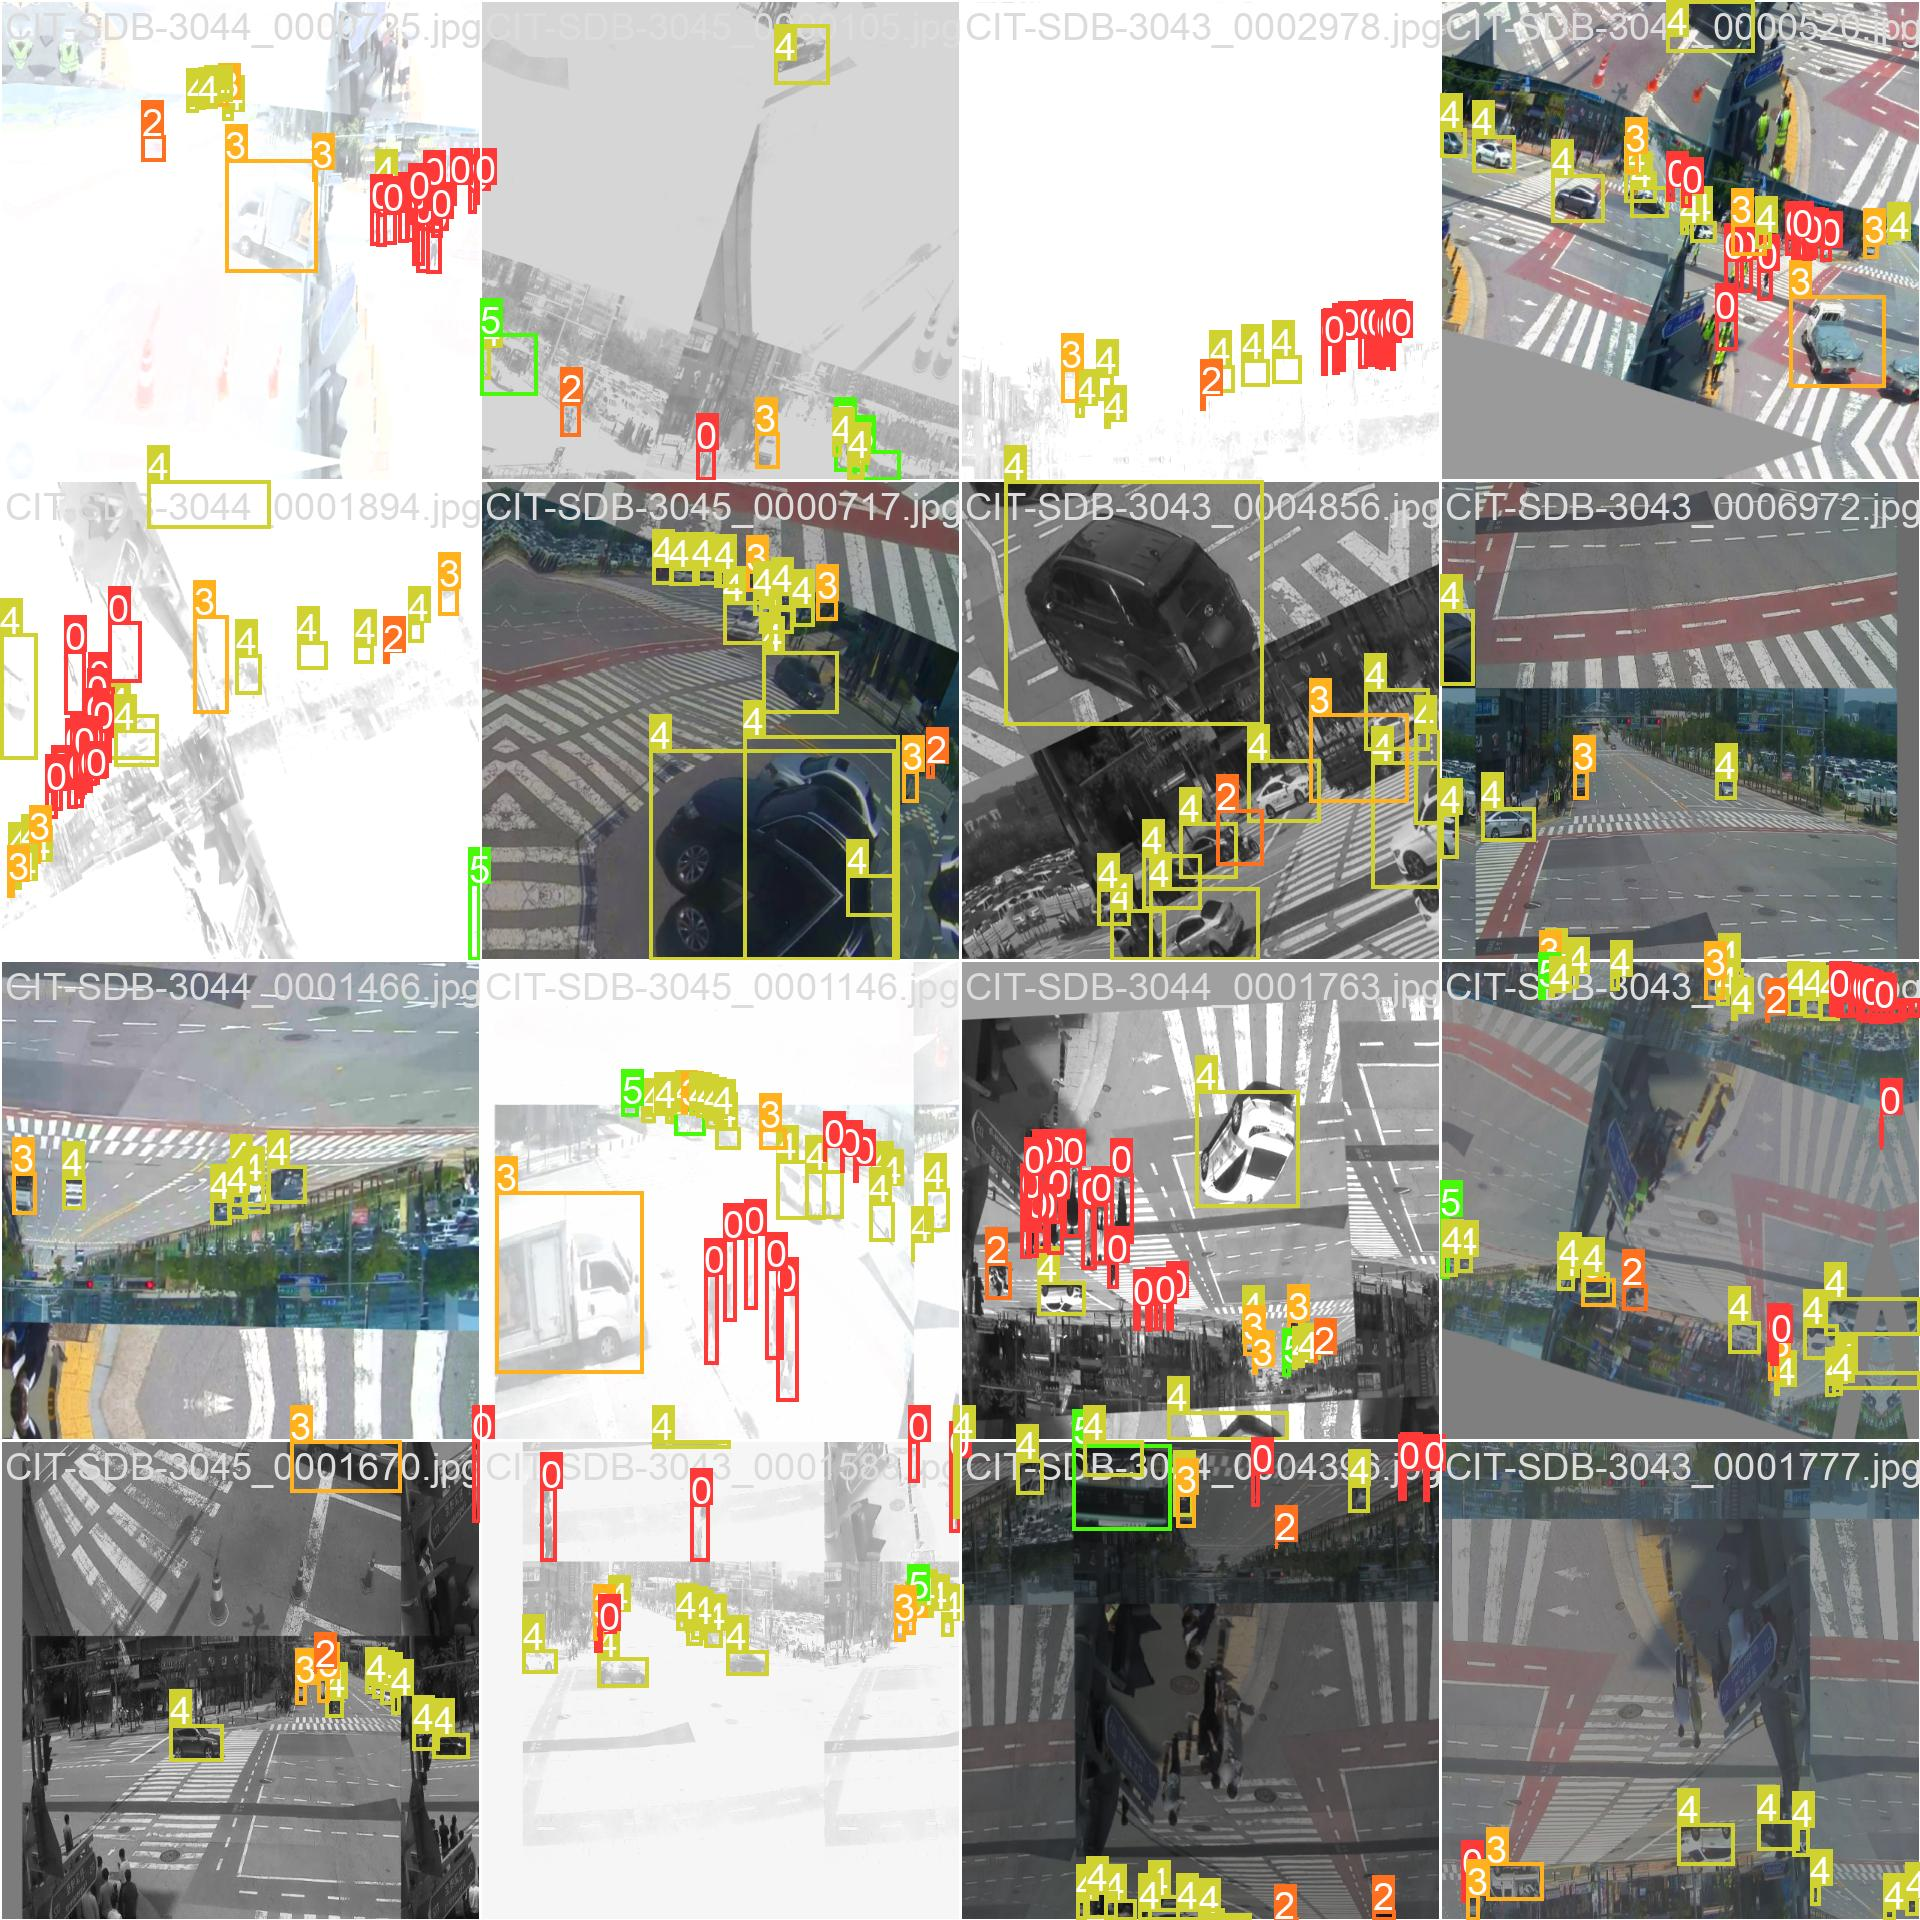

In [ ]:
Image(filename = 'runs/train/ai_results/train_batch1.jpg', width = 1000 )

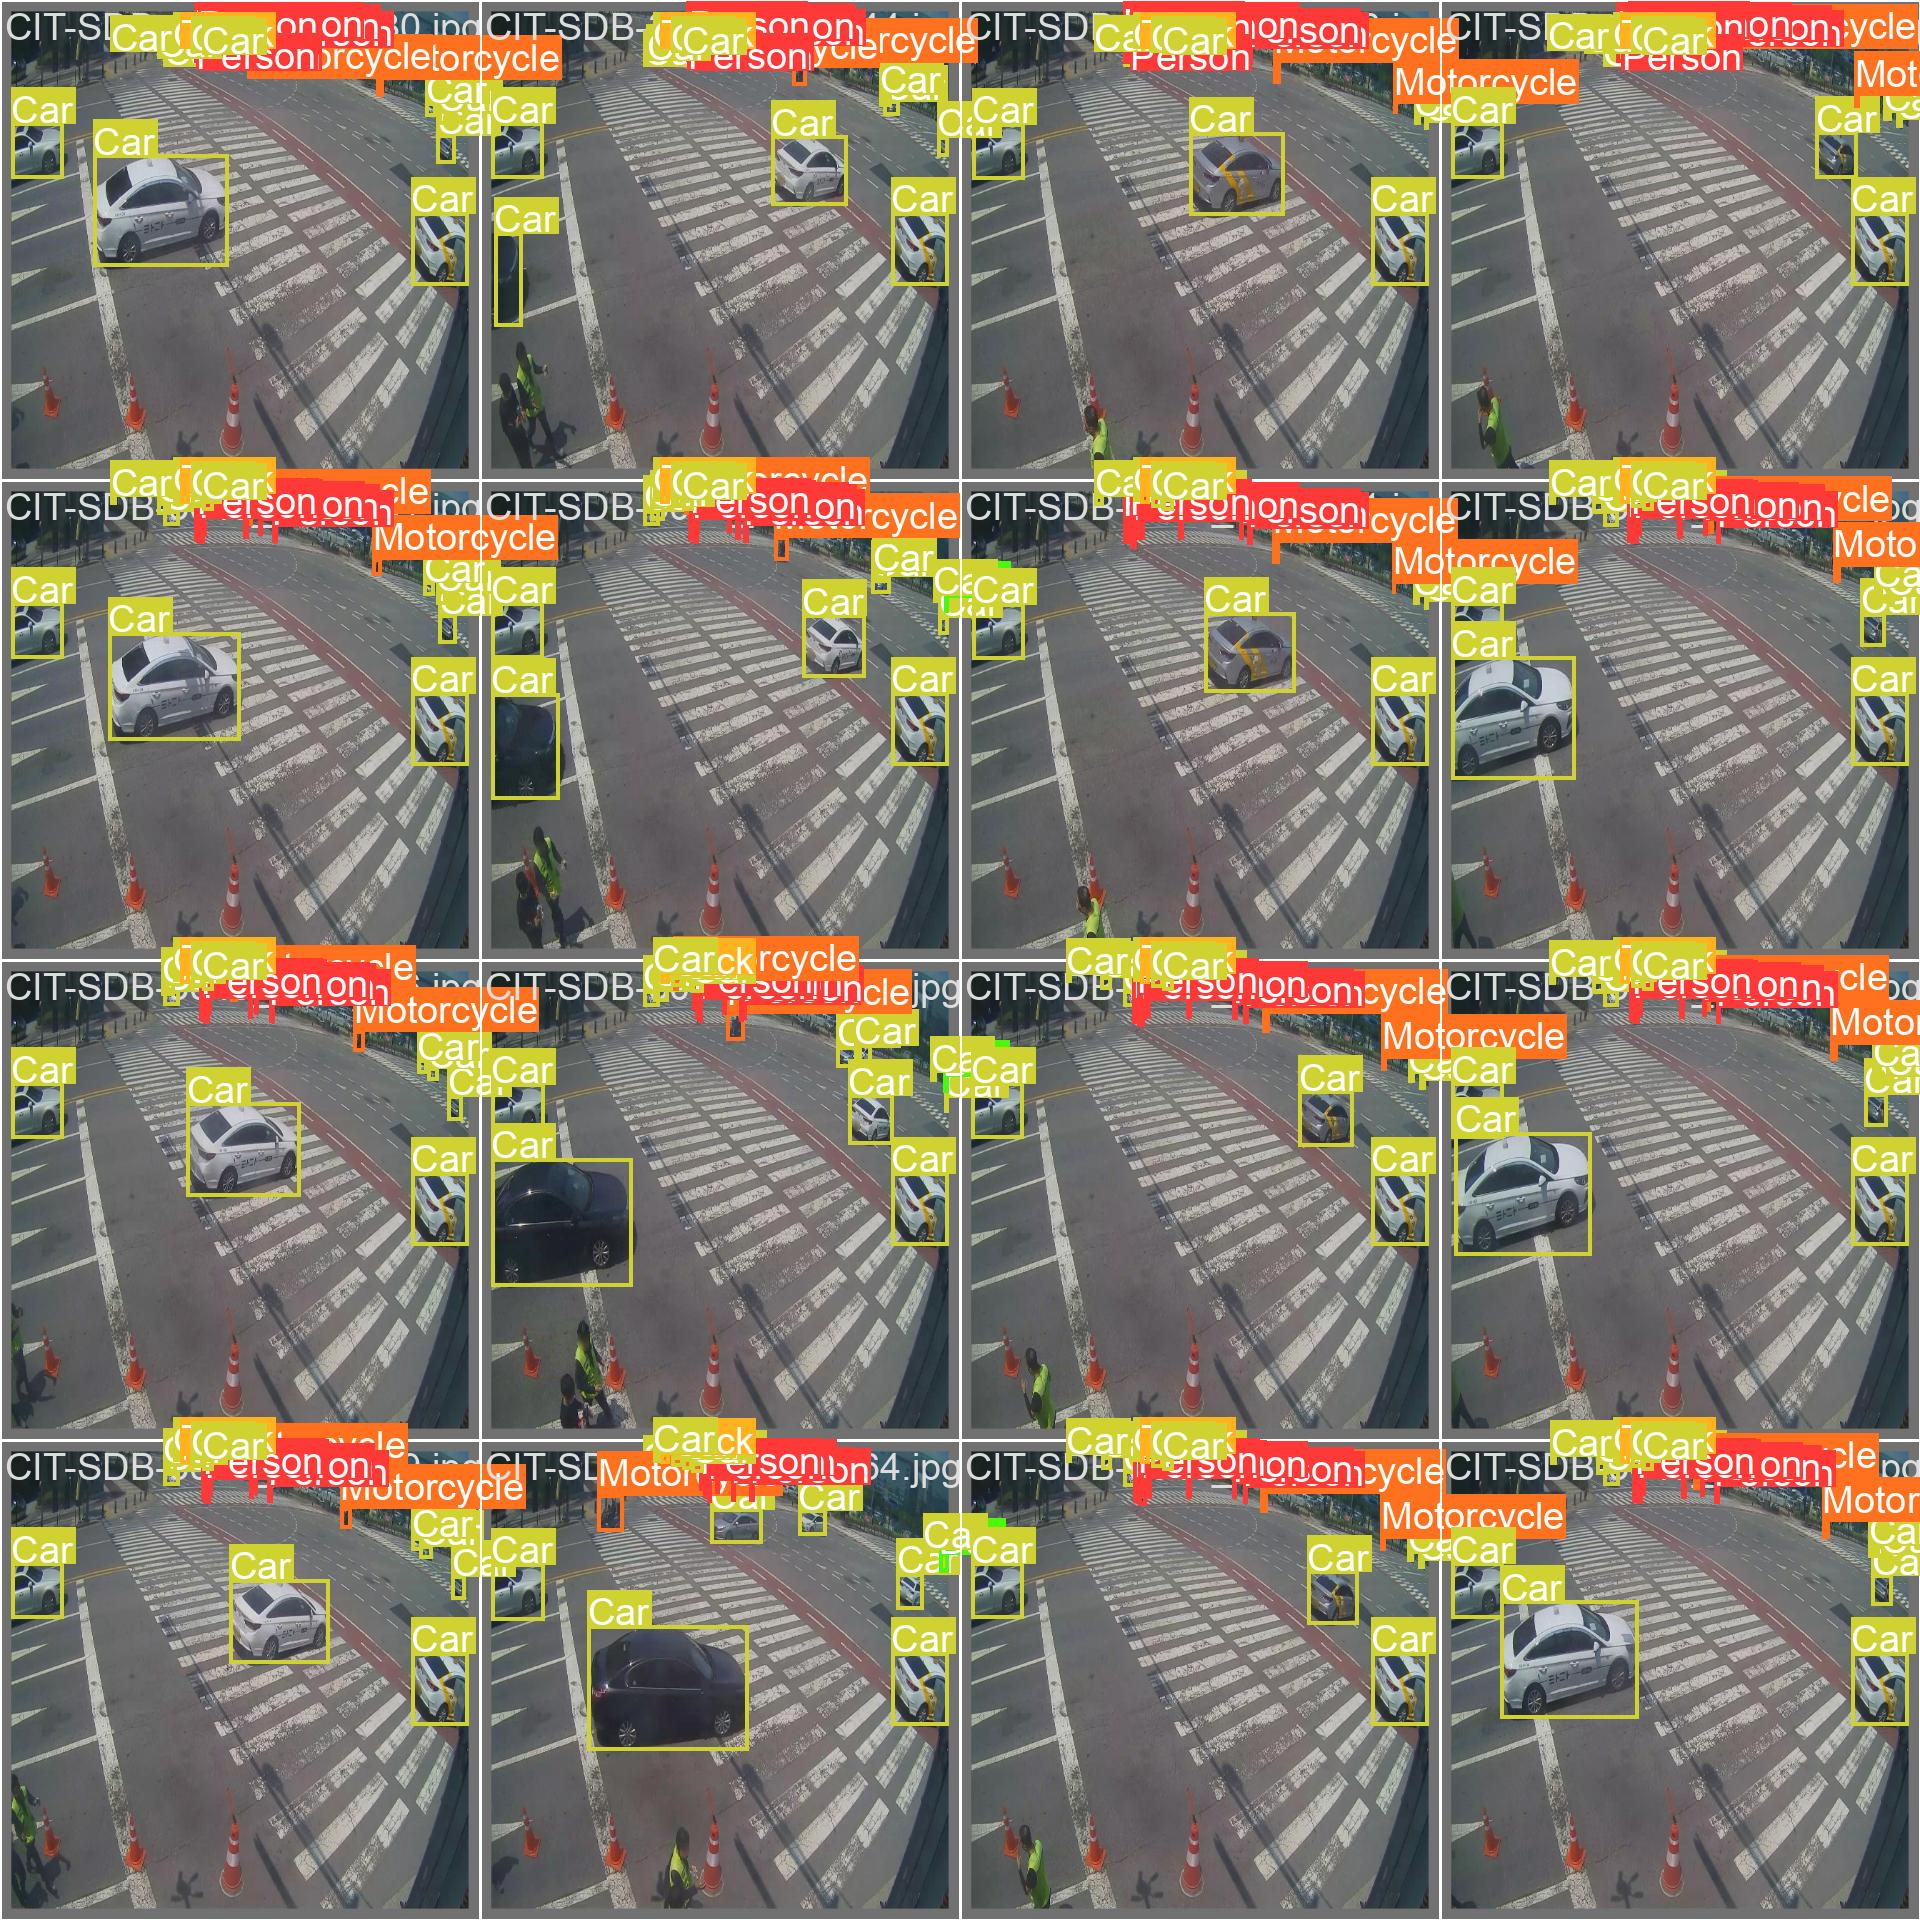

In [ ]:
Image(filename = 'runs/train/ai_results/val_batch0_labels.jpg', width = 1000 )

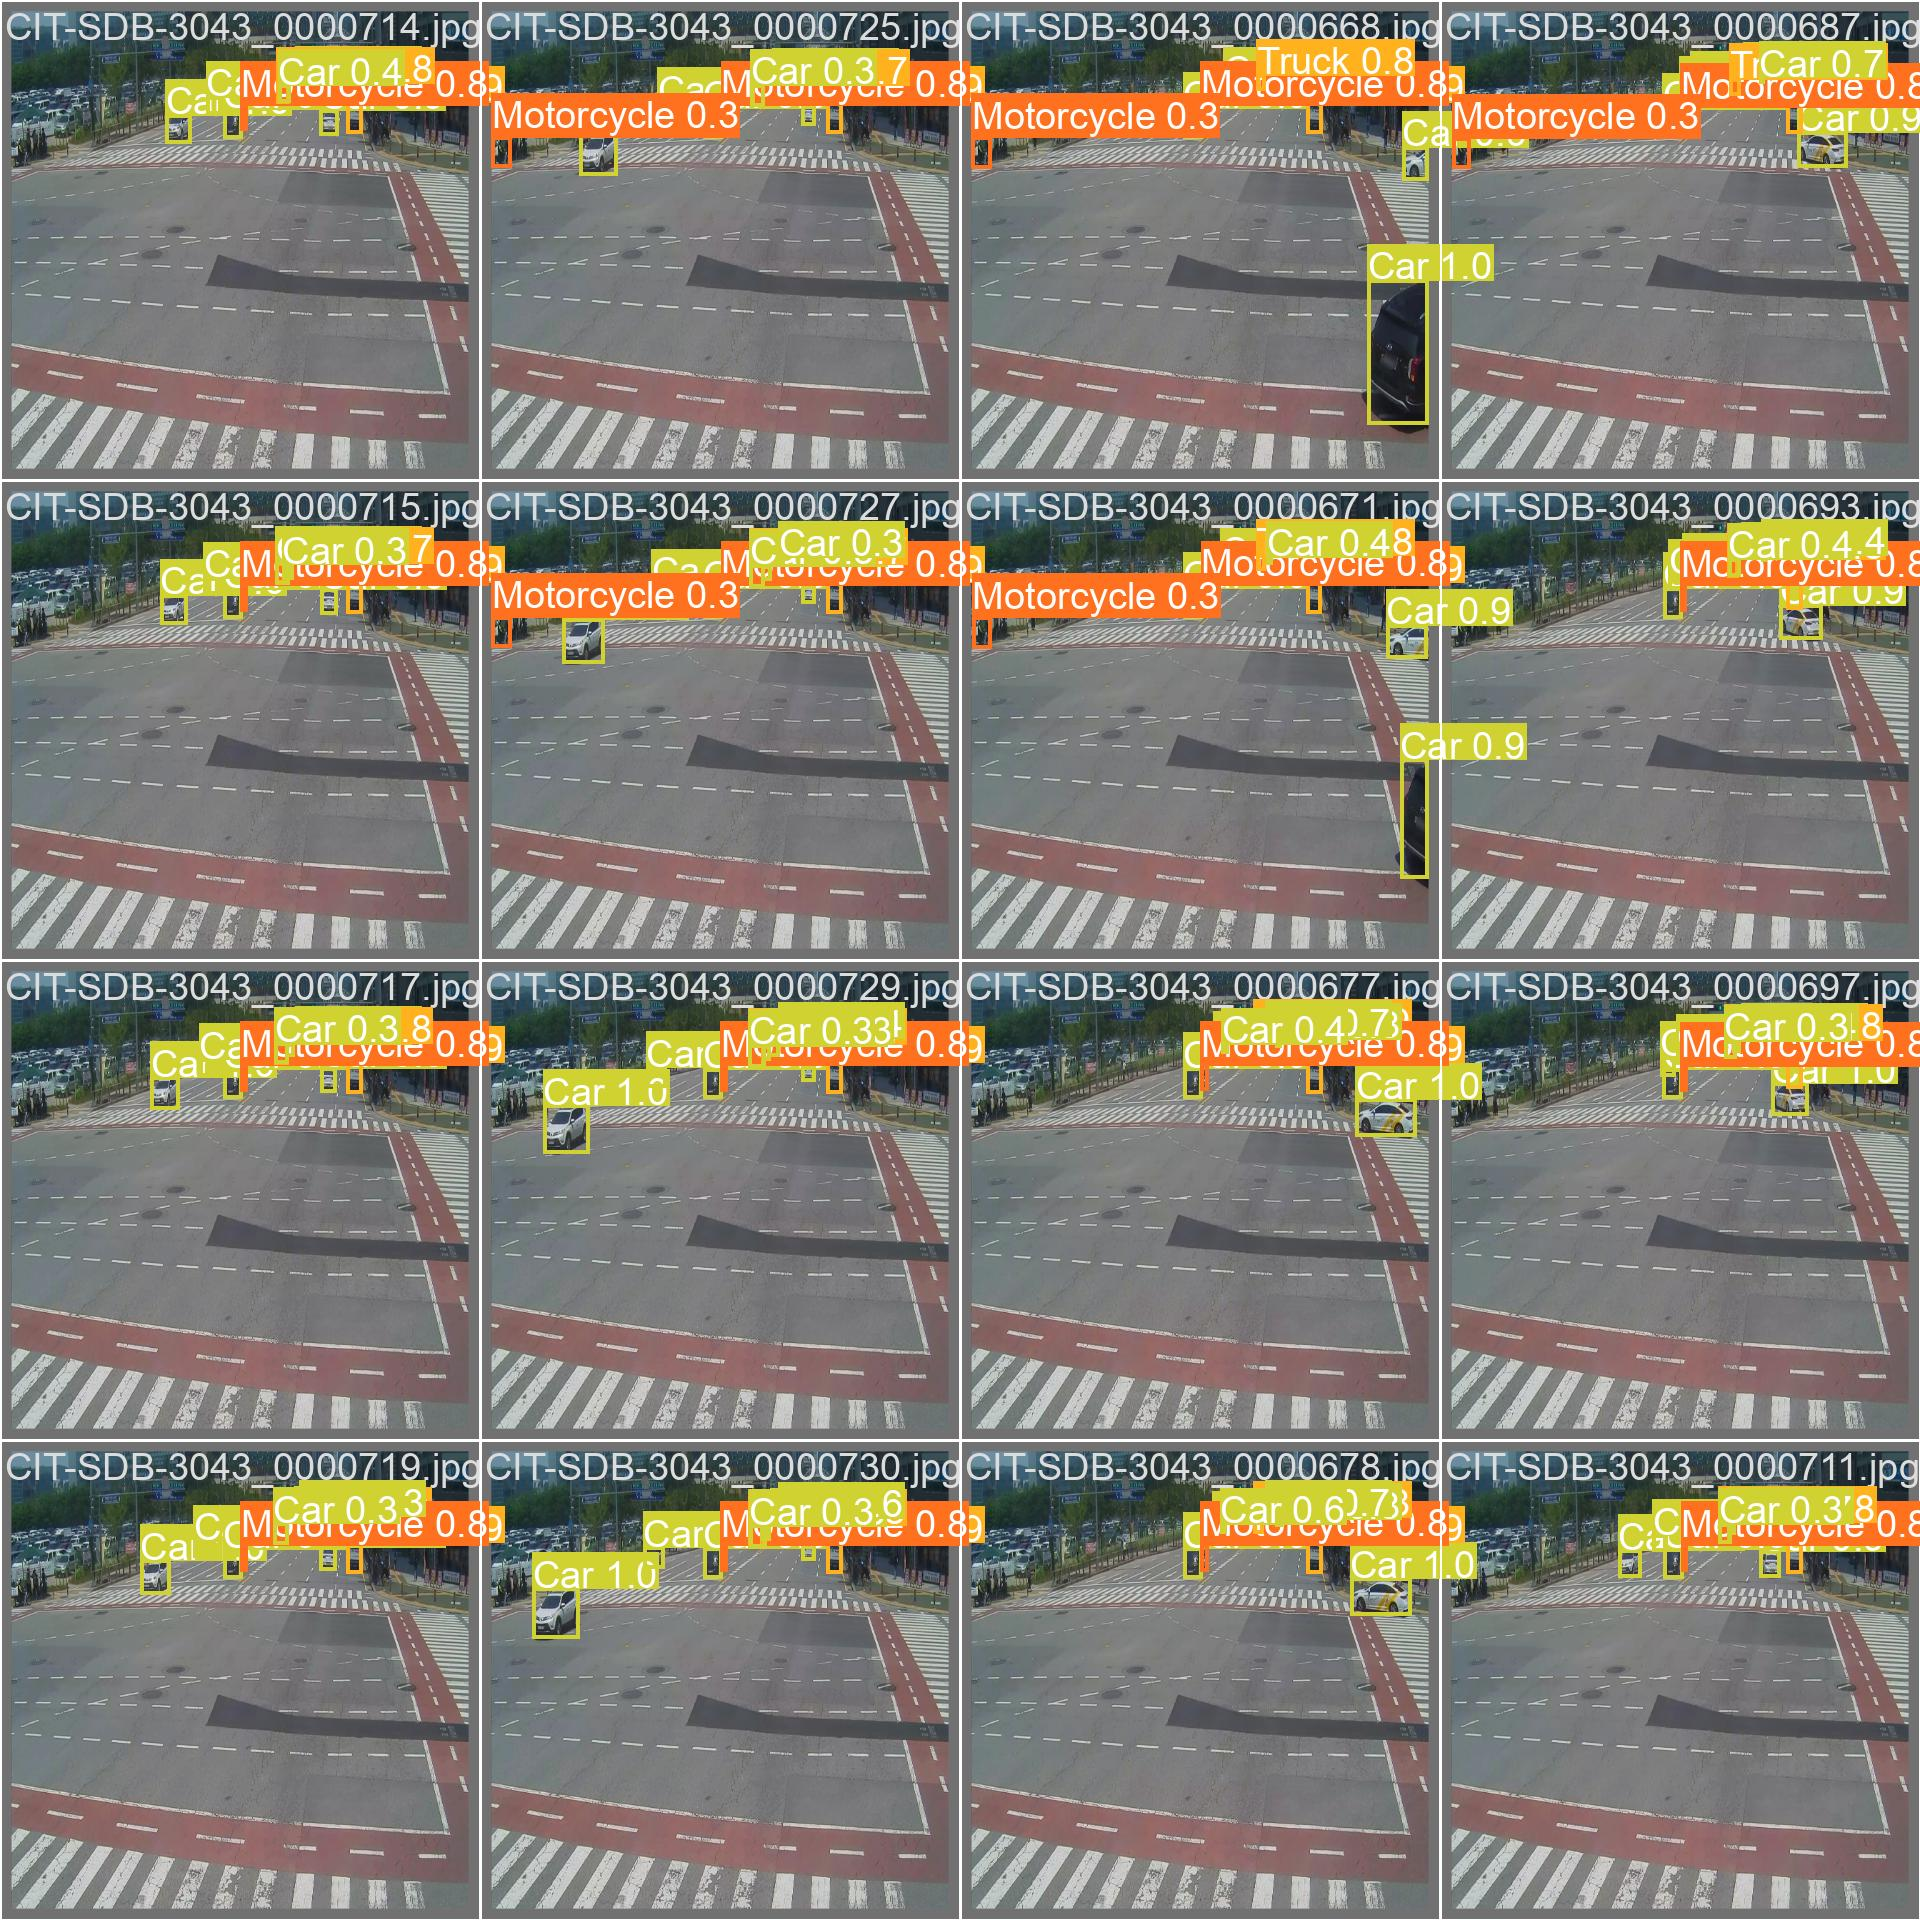

In [ ]:
Image(filename = '/content/yolov5/runs/train/ai_results/val_batch2_pred.jpg', width = 1000 )

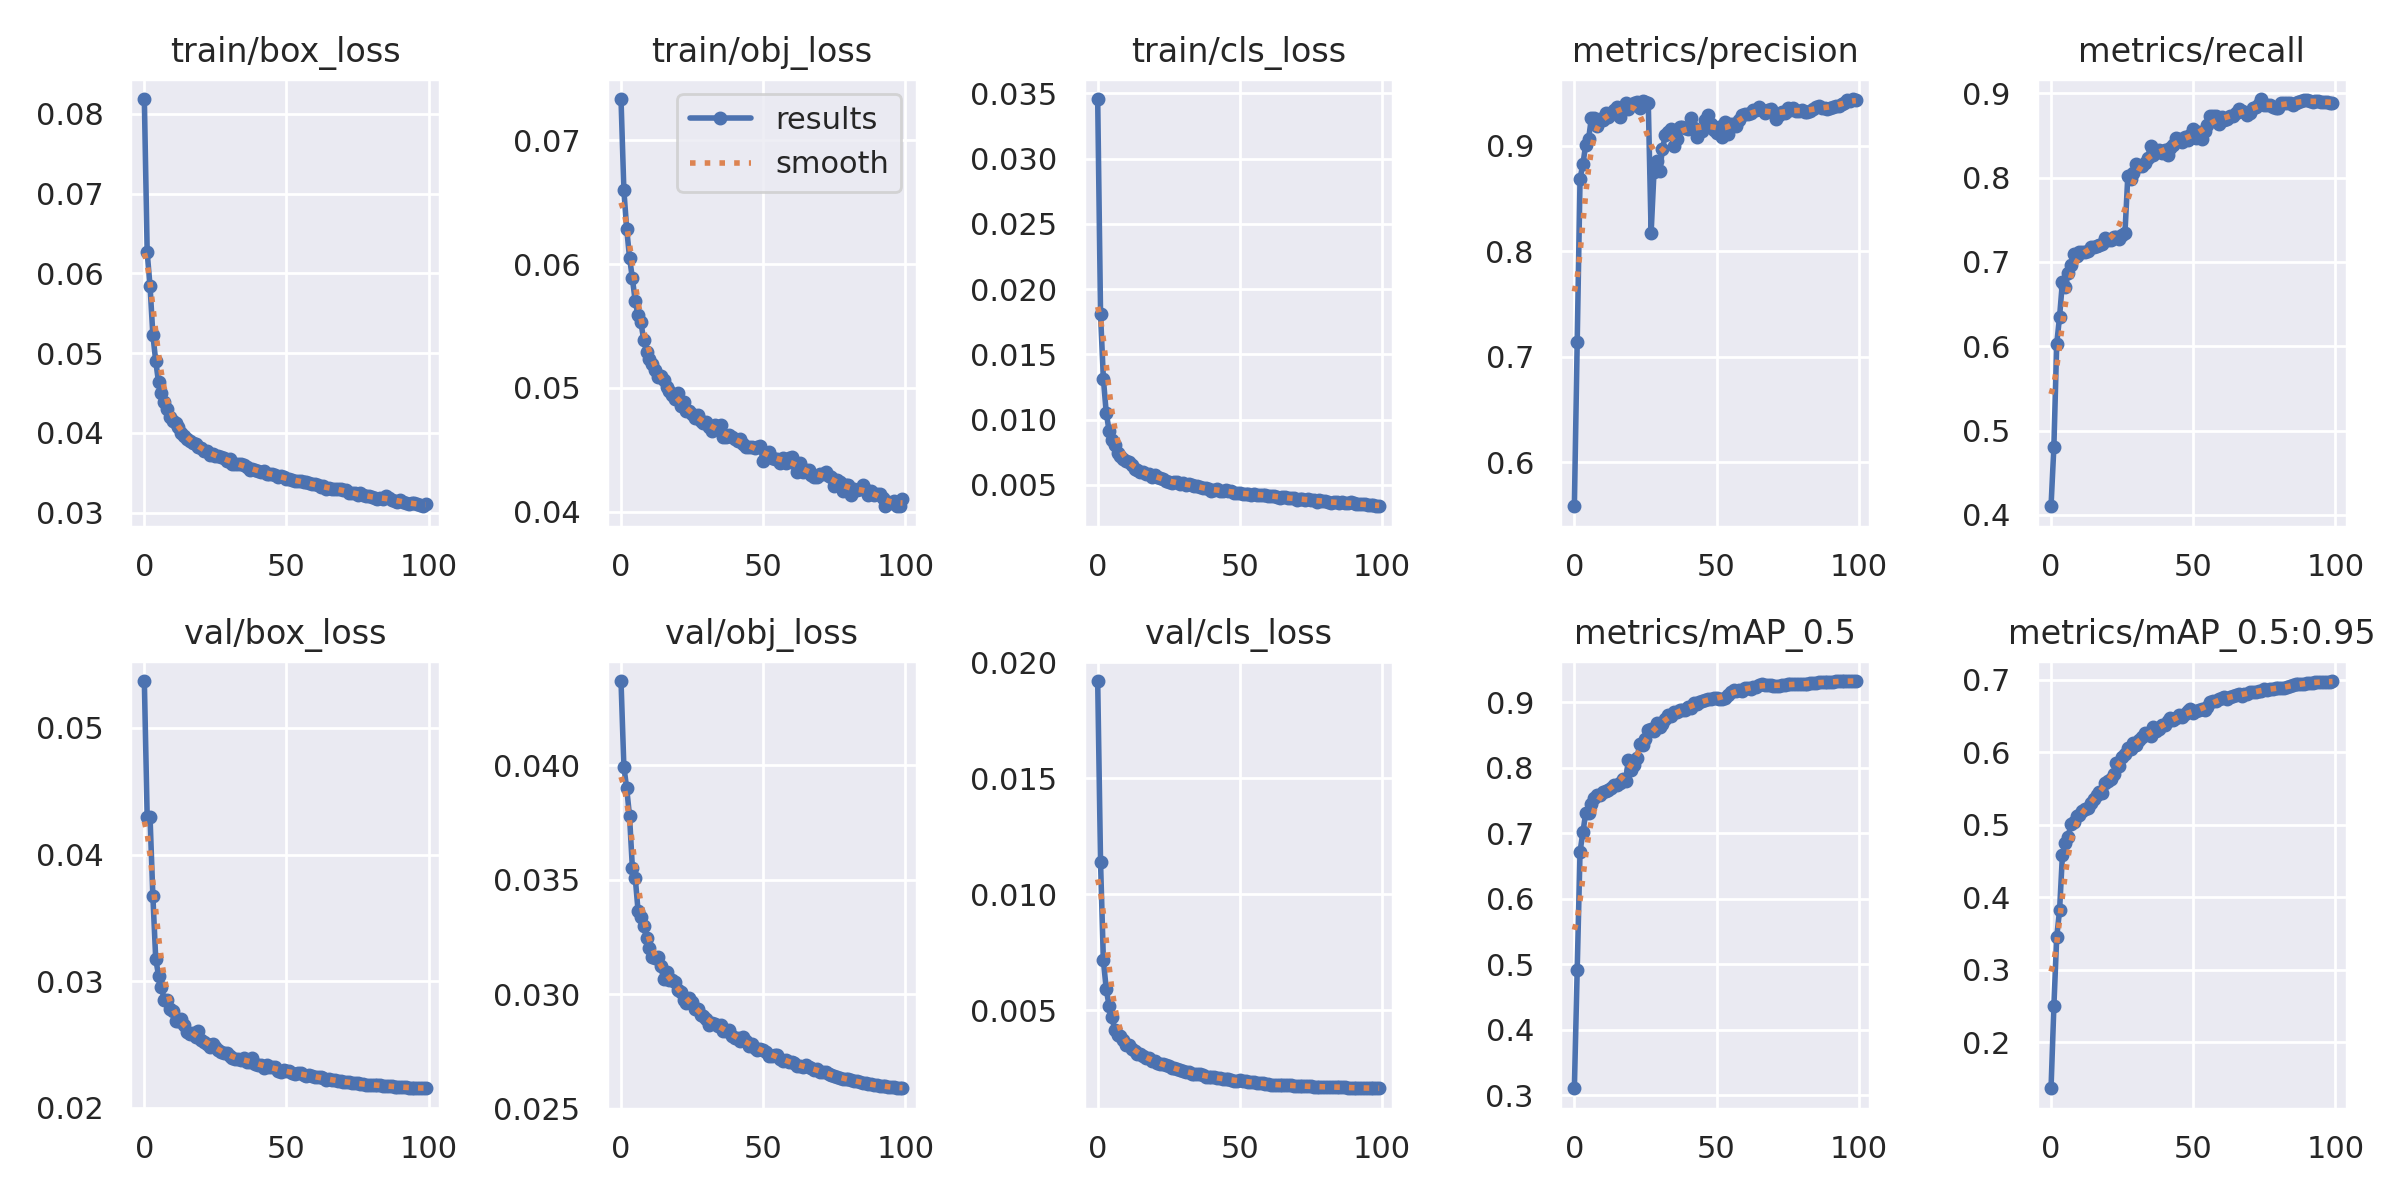

In [ ]:
Image(filename = '/content/yolov5/runs/train/ai_results/results.png', width = 1000 )

In [ ]:
# import shutil

# def download_drive_folder(drive_folder_path, local_zip_name):
#     shutil.make_archive(local_zip_name, 'zip', drive_folder_path)

# download_drive_folder('/content/yolov5/runs/train/ai_results2', 'local_zip_name')


In [ ]:
# from google.colab import files

# files.download('local_zip_name.zip')


In [ ]:
%cp  /content/yolov5/runs/train/ai_results/weights/best.pt /content/drive/MyDrive

## 검증(Validation)

In [ ]:
!python val.py --weights runs/train/ai_results/weights/best.pt --data /content/yolov5/ai_project/data.yaml --img 640 --iou 0.65 --half

val: data=/content/yolov5/ai_project/data.yaml, weights=['runs/train/ai_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-245-g3d8f004 Python-3.10.12 torch-2.1.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/ai_project/data_fold_0_val.cache... 4667 images, 0 backgrounds, 0 corrupt: 100% 4667/4667 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/yolov5/ai_project/train/images/CIT-SDB-3043_0001765.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /content/yolov5/ai_project/train/images/CIT-SDB-3043_0005801.jpg: 1 duplicate labels removed
                 Class     Images  Instances          P          R      m

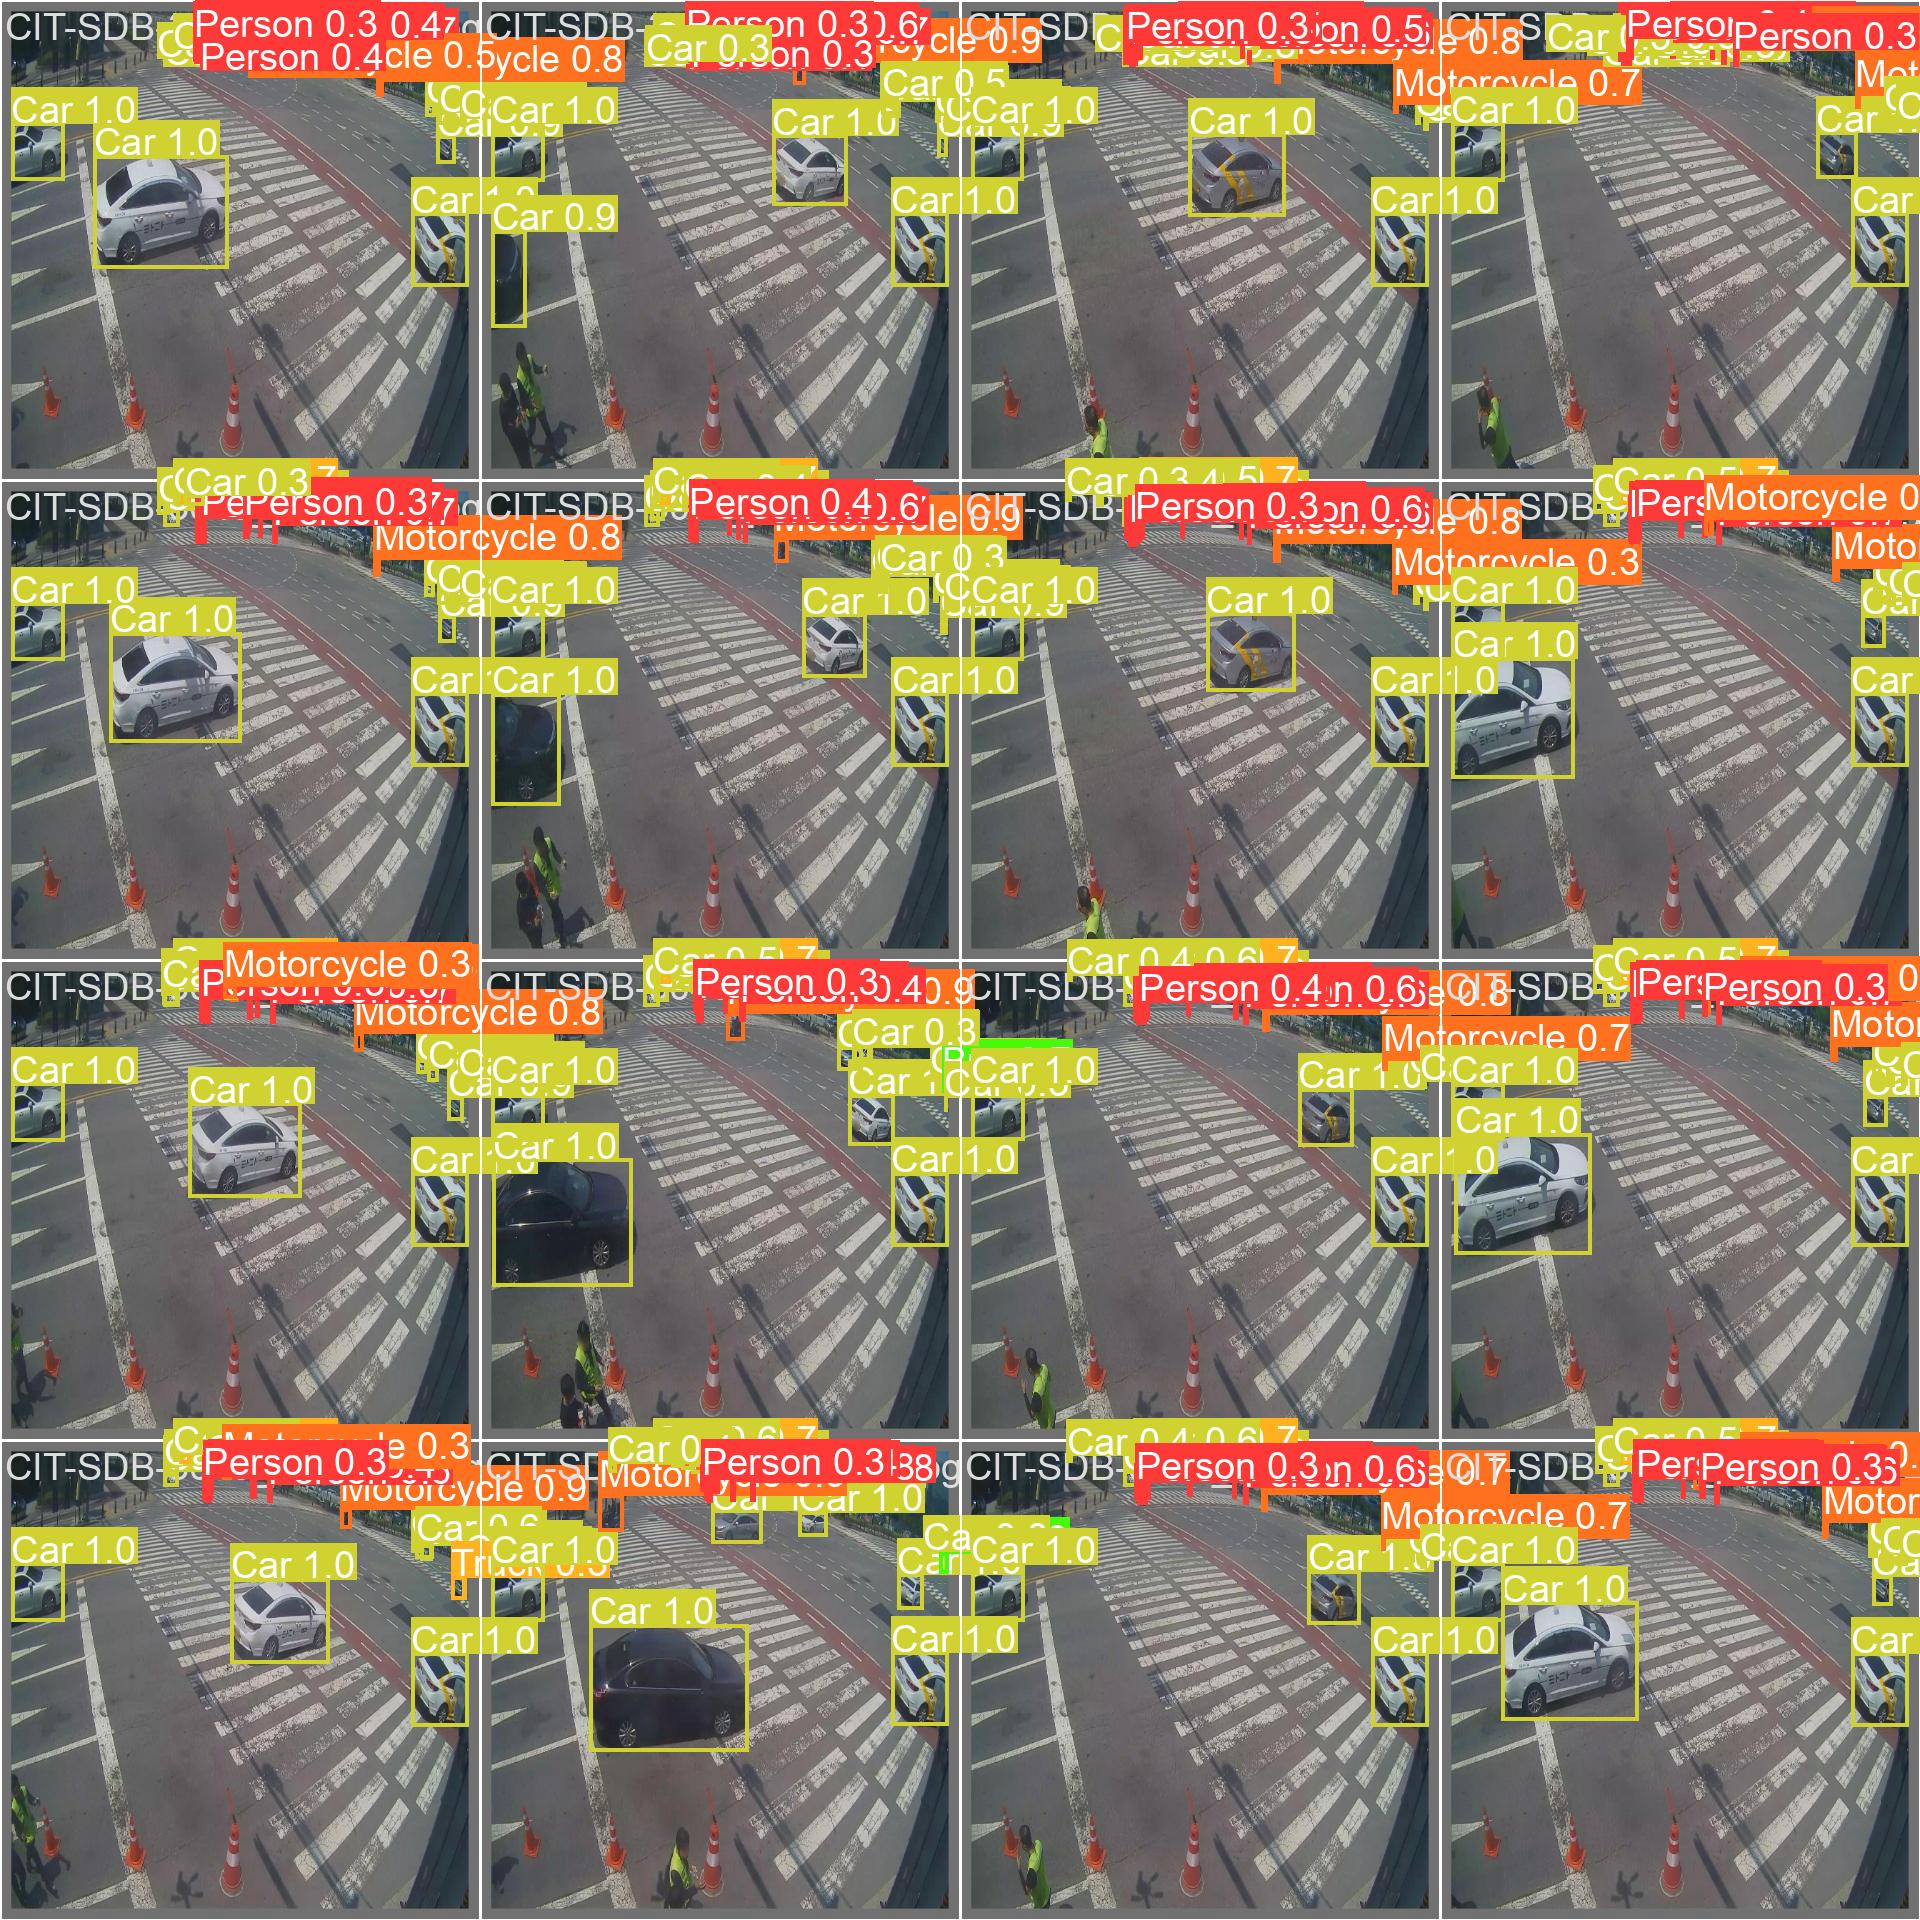

In [ ]:
Image(filename = '/content/yolov5/runs/val/exp/val_batch0_pred.jpg', width = 1000 )

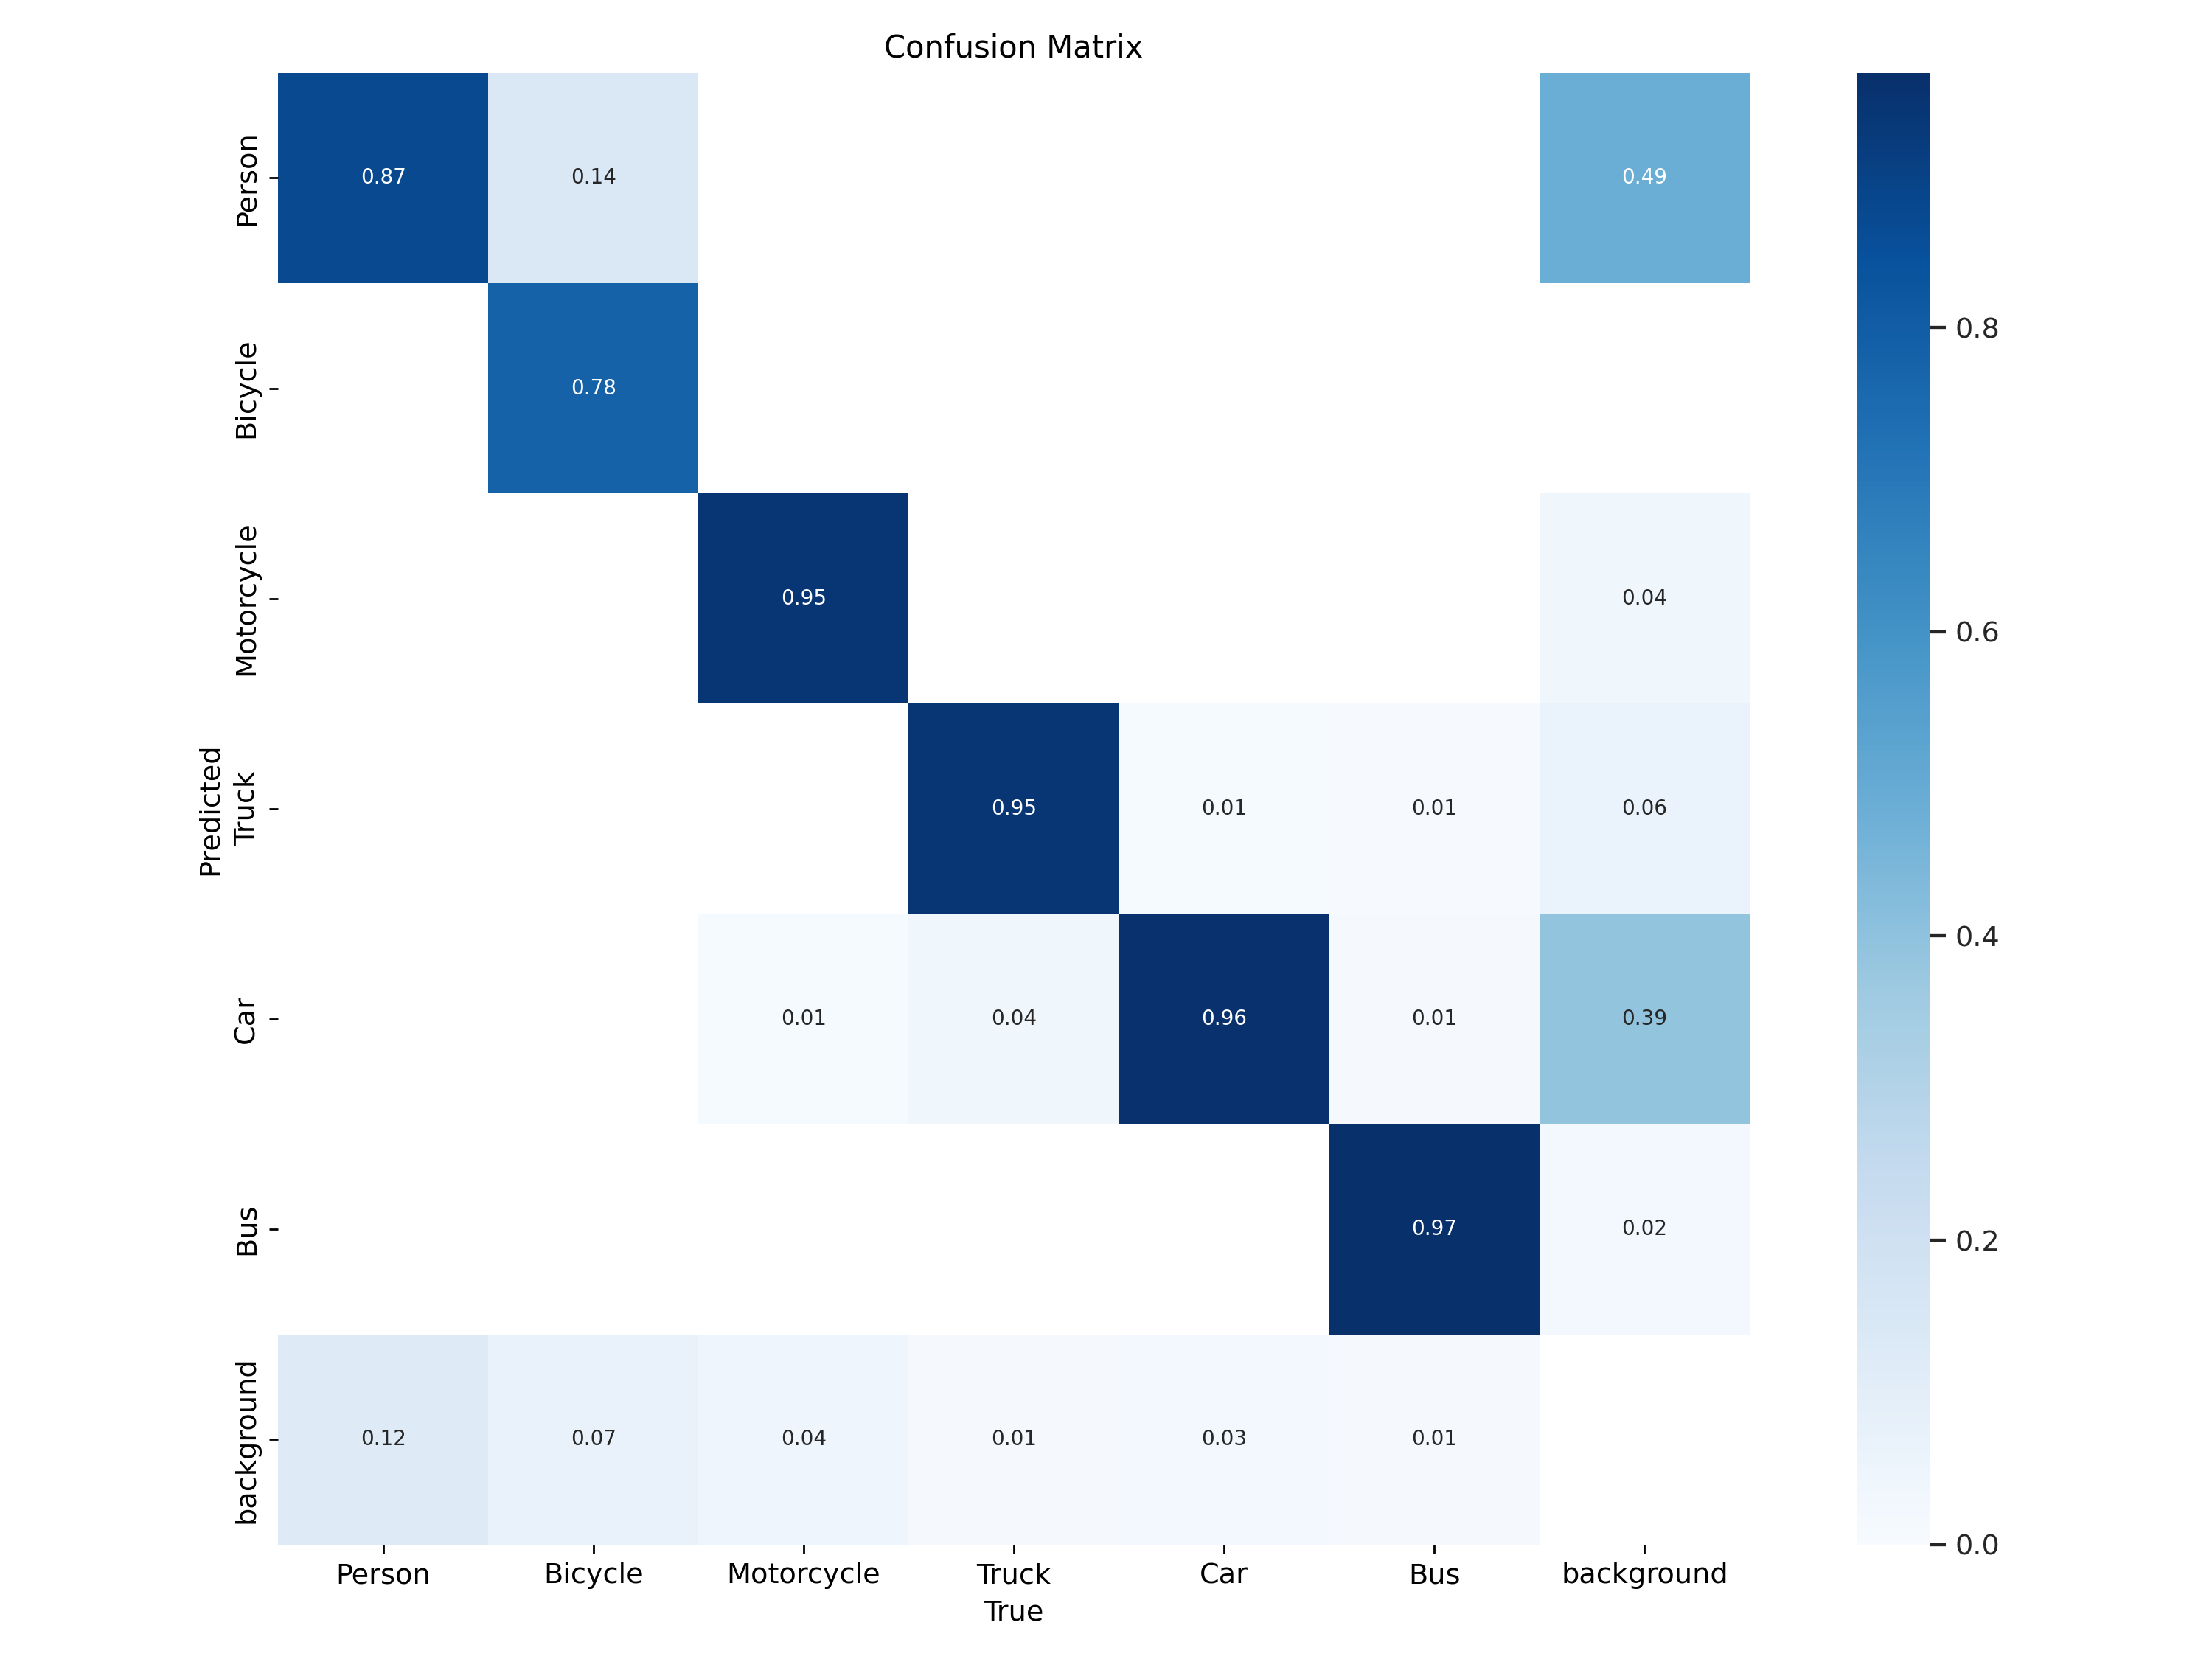

In [ ]:
Image(filename = '/content/yolov5/runs/val/exp/confusion_matrix.png', width = 1000 )

## 추론(Inference)

In [ ]:
%ls /content/yolov5/runs/train/ai_results/weights

best.pt  last.pt


In [ ]:
!python detect.py --weights /content/yolov5/runs/train/ai_results/weights/best.pt --img 640 --conf 0.4 --source //content/yolov5/ai_project/test/images

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 1003/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003416.jpg: 384x640 4 Persons, 2 Trucks, 8 Cars, 1 Bus, 7.6ms
image 1004/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003417.jpg: 384x640 4 Persons, 3 Trucks, 8 Cars, 1 Bus, 7.6ms
image 1005/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003419.jpg: 384x640 5 Persons, 3 Trucks, 7 Cars, 7.6ms
image 1006/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003424.jpg: 384x640 4 Persons, 3 Trucks, 6 Cars, 1 Bus, 7.6ms
image 1007/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003426.jpg: 384x640 5 Persons, 3 Trucks, 7 Cars, 7.6ms
image 1008/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003427.jpg: 384x640 4 Persons, 1 Motorcycle, 3 Trucks, 6 Cars, 7.5ms
image 1009/6000 /content/yolov5/ai_project/test/images/CIT-SDB-3043_0003441.jpg: 384x640 4 Persons, 1 Motorcycle, 3 Trucks, 6 Cars, 7.6ms
image 1010/6000 /content/yolov5/ai_project/test

In [ ]:
import glob
import random
from IPython.display import Image,display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display (Image(filename = image_name))

IndexError: ignored

In [ ]:
import torch
from PIL import Image
import json

# YOLO 모델 로드
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# 이미지 로드 및 객체 검출
img = '/content/yolov5/ai_project/test/images/CIT-SDB-3043_0000028.jpg'
results = model(img)

# 검출 결과 추출
detections = results.pandas().xyxy[0].to_json(orient="records")
detections = json.loads(detections)

In [ ]:
# 결과를 JSON 파일로 저장
with open('detection_results.json', 'w') as f:
    json.dump(detections, f, indent=4)


In [ ]:
import torch
from pathlib import Path
import json

# YOLO 모델 로드
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# 테스트 데이터셋 폴더
test_folder = Path('path/to/your/test/dataset')

# 검출 결과를 저장할 리스트
detection_results = []

# 테스트 데이터셋의 모든 이미지에 대해 객체 검출 실행
for img_path in test_folder.glob('*.jpg'):  # '.jpg' 확장자를 가진 모든 파일에 대해
    # 이미지로 객체 검출 실행
    results = model(str(img_path))

    # 검출 결과 추출 및 저장
    detections = results.pandas().xyxy[0].to_json(orient="records")
    detection_results.append({
        "image": str(img_path),
        "detections": json.loads(detections)
    })

# 검출 결과를 JSON 파일로 저장
with open('detection_results.json', 'w') as f:
    json.dump(detection_results, f, indent=4)
